In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2 as cv
import os
from tqdm import tqdm
import pickle
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [2]:
# # Define your dataset directory and labels
# base_dir = r'C:\Notebooks\Sign_language_detector'
# train_dir = os.path.join(base_dir, 'asl_dataset')

train_dir = 'asl_dataset'

# SVM Classification

In [3]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [4]:
# Load and preprocess the data
def load_and_preprocess_data_svm(base_dir, labels, img_size):
    data = []
    labels_encoded = []

    for label in labels:
        folderpath = os.path.join(train_dir, label)
        for image_name in tqdm(os.listdir(folderpath)):
            img = cv.imread(os.path.join(folderpath, image_name))
            img = cv.resize(img, (img_size, img_size))
            data.append(img)
            labels_encoded.append(labels.index(label))

    data = np.array(data)

    return data, labels_encoded

In [5]:
# Split the data into training and testing sets
img_size = 224
Xs,ys=load_and_preprocess_data_svm(train_dir, labels, img_size)
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(Xs, ys, test_size=0.1, random_state=101)

100%|██████████| 70/70 [00:00<00:00, 277.15it/s]


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train_flat = X_train_svm.reshape(X_train_svm.shape[0], -1)
X_test_flat = X_test_svm.reshape(X_test_svm.shape[0], -1)

# Initialize SVM model
svm_model = SVC(kernel='linear', C=1.0)

# Train the SVM model
svm_model.fit(X_train_flat, y_train_svm)

# Make predictions on the test set
y_pred = svm_model.predict(X_test_flat)



In [7]:
accuracy = accuracy_score(y_test_svm, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

pickle.dump(svm_model, open('svm_model.pkl', 'wb'))

Accuracy: 97.22%


# Classification using Feature extraction

In [8]:
def load_and_preprocess_data(base_dir, labels, img_size):
    data = []
    labels_encoded = []

    for label in labels:
        folderpath = os.path.join(train_dir, label)
        for image_name in tqdm(os.listdir(folderpath)):
            img = cv.imread(os.path.join(folderpath, image_name))
            img = cv.resize(img, (img_size, img_size))
            data.append(img)
            labels_encoded.append(labels.index(label))

    data = np.array(data)
    labels_encoded = to_categorical(labels_encoded, num_classes=len(labels))

    return data, labels_encoded

In [9]:
img_size = 224
X, y = load_and_preprocess_data(train_dir, labels, img_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)


100%|██████████| 70/70 [00:00<00:00, 341.36it/s]


In [10]:
# Build a custom neural network model
model = Sequential()
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(len(labels), activation='softmax'))

In [11]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
71/71 [==============================] - 22s 281ms/step - loss: 2.3857 - accuracy: 0.4463 - val_loss: 2.8402 - val_accuracy: 0.2222
Epoch 2/10
71/71 [==============================] - 22s 309ms/step - loss: 1.2929 - accuracy: 0.7742 - val_loss: 1.6402 - val_accuracy: 0.7421
Epoch 3/10
71/71 [==============================] - 20s 287ms/step - loss: 0.7949 - accuracy: 0.8652 - val_loss: 0.9192 - val_accuracy: 0.8373
Epoch 4/10
71/71 [==============================] - 20s 280ms/step - loss: 0.4983 - accuracy: 0.9129 - val_loss: 0.6343 - val_accuracy: 0.8770
Epoch 5/10
71/71 [==============================] - 20s 280ms/step - loss: 0.3347 - accuracy: 0.9510 - val_loss: 0.4622 - val_accuracy: 0.8929
Epoch 6/10
71/71 [==============================] - 20s 283ms/step - loss: 0.2359 - accuracy: 0.9673 - val_loss: 0.3700 - val_accuracy: 0.9286
Epoch 7/10
71/71 [==============================] - 20s 280ms/step - loss: 0.1599 - accuracy: 0.9823 - val_loss: 0.2471 - val_accuracy: 0.9484

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy*100:.2f}')

# Save the model
model.save('custom_sign_language_model_without_conv.h5')


8/8 [==============================] - 0s 31ms/step - loss: 0.2581 - accuracy: 0.9444
Test accuracy: 94.44


c:\Users\Parth Tripathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [13]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(len(labels), activation='softmax'))

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
71/71 [==============================] - 132s 2s/step - loss: 2.1196 - accuracy: 0.5241 - val_loss: 2.2689 - val_accuracy: 0.5198
Epoch 2/10
71/71 [==============================] - 123s 2s/step - loss: 0.9046 - accuracy: 0.8856 - val_loss: 1.3542 - val_accuracy: 0.8730
Epoch 3/10
71/71 [==============================] - 121s 2s/step - loss: 0.4413 - accuracy: 0.9593 - val_loss: 0.6956 - val_accuracy: 0.9405
Epoch 4/10
71/71 [==============================] - 121s 2s/step - loss: 0.2320 - accuracy: 0.9837 - val_loss: 0.5242 - val_accuracy: 0.9444
Epoch 5/10
71/71 [==============================] - 122s 2s/step - loss: 0.1353 - accuracy: 0.9951 - val_loss: 0.6273 - val_accuracy: 0.9246
Epoch 6/10
71/71 [==============================] - 120s 2s/step - loss: 0.0770 - accuracy: 0.9987 - val_loss: 0.2578 - val_accuracy: 0.9603
Epoch 7/10
71/71 [==============================] - 117s 2s/step - loss: 0.0493 - accuracy: 1.0000 - val_loss: 0.2115 - val_accuracy: 0.9524
Epoch 8/10
71

8/8 [==============================] - 2s 265ms/step


<Figure size 1000x1200 with 0 Axes>

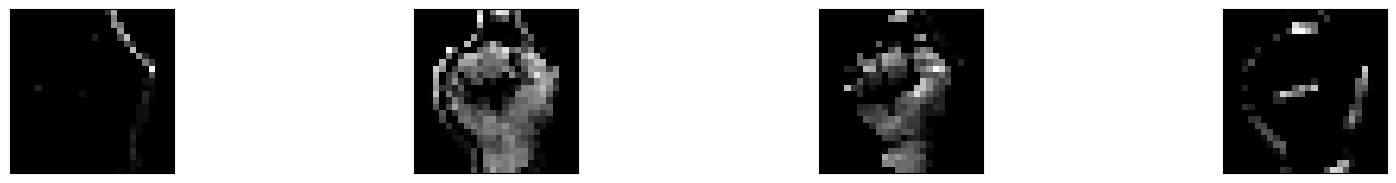

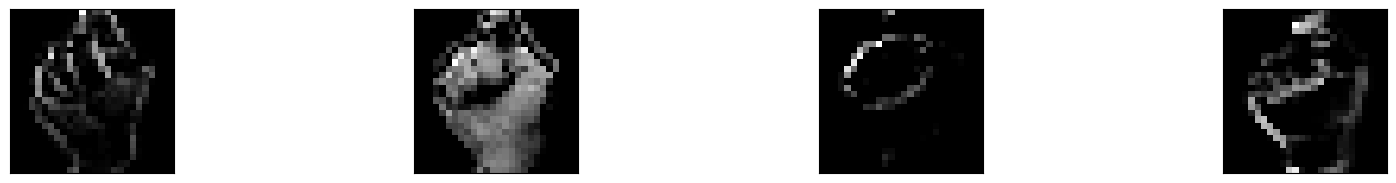

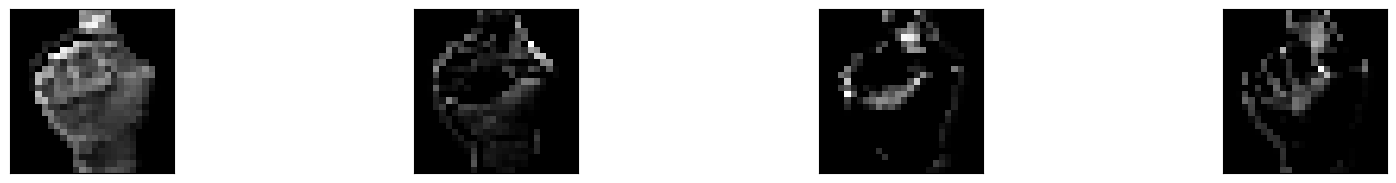

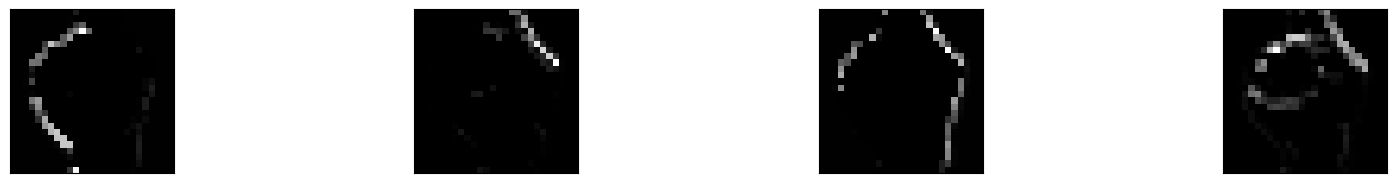

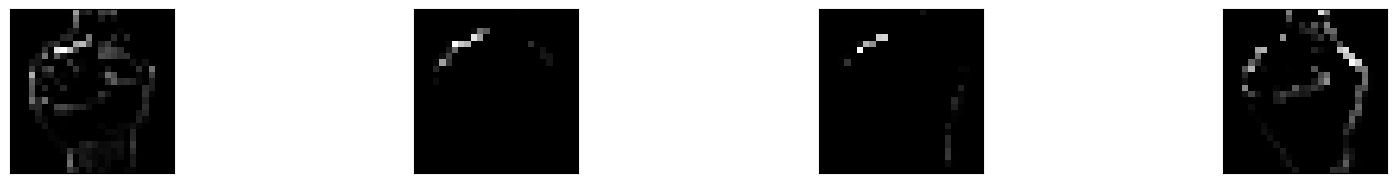

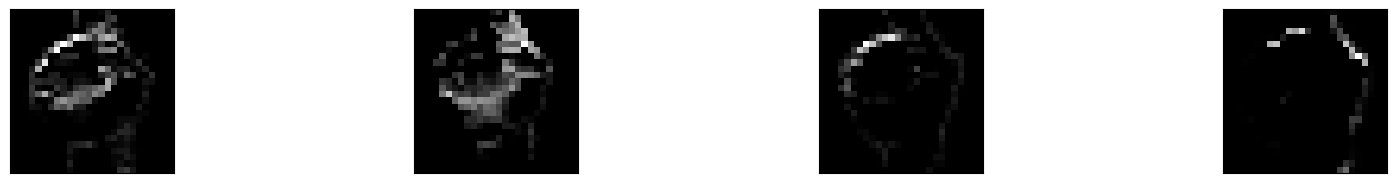

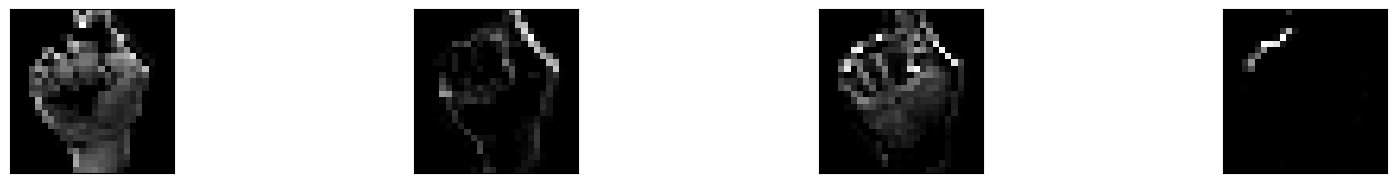

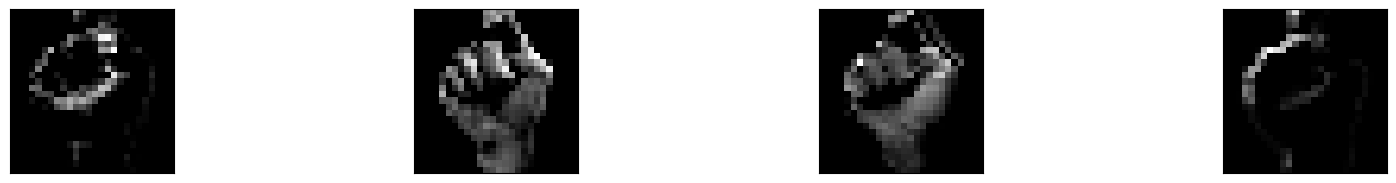

In [15]:
# Extract feature maps from the convolutional layer
import matplotlib.pyplot as plt
layer_outputs = [layer.output for layer in model.layers[:6]]
activation_model = Sequential(model.layers[:6])
feature_maps = activation_model.predict(X_test)

# Visualize feature maps
square1 = 8
square2 = 4
ix = 1

plt.figure(figsize=(10, 12))

for _ in range(square1):
    plt.figure(figsize=(20, 20))
    for _ in range(square2):
        # specify subplot and turn off axis
        ax = plt.subplot(square1, square2, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        # plot filter channel in grayscale
        plt.imshow(feature_maps[10, :, :, ix-1], cmap='gray')
        ix += 1

# show the figure
plt.show()

In [16]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {100 * test_accuracy:.2f}%')

# Save the model
model.save('custom_sign_language_model_with_conv.h5')


8/8 [==============================] - 2s 278ms/step - loss: 0.1290 - accuracy: 0.9563
Test accuracy: 95.63%


c:\Users\Parth Tripathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Feature Extraction using pi wavelet transform


In [17]:
import pywt

def pi_wavelet_transform(train_dir, labels, img_size):
    labels_encoded = []
    transformed_data = []

    for label in labels:
        folderpath = os.path.join(train_dir, label)
        for image_name in tqdm(os.listdir(folderpath)):
            # Load the image in grayscale
            img = cv.imread(os.path.join(folderpath, image_name),cv.IMREAD_GRAYSCALE)
            # Resize the image to the desired size
            img = cv.resize(img, (img_size, img_size))

            # Apply the pi wavelet transform
            coeffs2 = pywt.dwt2(img, 'haar')
            LL, (LH, HL, HH) = coeffs2
            LL = np.expand_dims(LL, axis=2)
            LH = np.expand_dims(LH, axis=2)
            HL = np.expand_dims(HL, axis=2)
            HH = np.expand_dims(HH, axis=2)

            # Concatenate the wavelet coefficients
            features = np.concatenate([LL, LH, HL, HH], axis=0)
            transformed_data.append(features)
            labels_encoded.append(labels.index(label))

        X_wave = np.array(transformed_data)
        y_wave = np.array(labels_encoded)


    return X_wave, y_wave

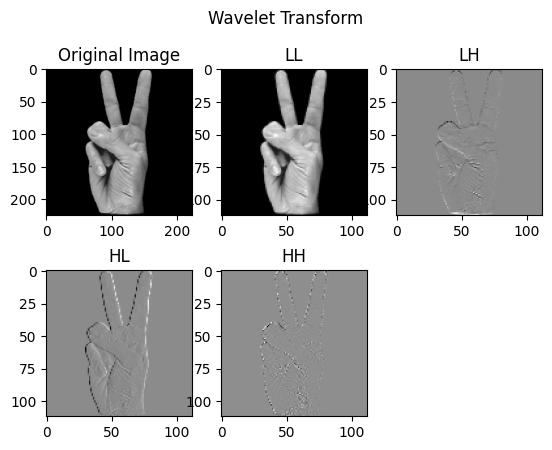

In [18]:
import matplotlib.pyplot as plt

def visualize_wavelet_transform(original_img, transformed_coeffs, title):
    # Display the original image
    plt.subplot(2, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')

    # Display the LL sub-band
    plt.subplot(2, 3, 2)
    plt.imshow(transformed_coeffs[0], cmap='gray')
    plt.title('LL')

    # Display the LH sub-band
    plt.subplot(2, 3, 3)
    plt.imshow(transformed_coeffs[1], cmap='gray')
    plt.title('LH')

    # Display the HL sub-band
    plt.subplot(2, 3, 4)
    plt.imshow(transformed_coeffs[2], cmap='gray')
    plt.title('HL')

    # Display the HH sub-band
    plt.subplot(2, 3, 5)
    plt.imshow(transformed_coeffs[3], cmap='gray')
    plt.title('HH')

    plt.suptitle(title)
    plt.show()

# Example usage:
# Assuming img is the original image and coeffs2 is the wavelet coefficients
img = cv.imread('asl_dataset/2/hand1_2_bot_seg_2_cropped.jpeg', cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (img_size, img_size))
coeffs2 = pywt.dwt2(img, 'haar')
LL, (LH, HL, HH) = coeffs2

# Visualize the transformation
visualize_wavelet_transform(img, [LL, LH, HL, HH], 'Wavelet Transform')


In [19]:
img_size = 224
X_wave, y_wave = pi_wavelet_transform(train_dir, labels, img_size)
X_train_wave, X_test_wave, y_train_wave, y_test_wave = train_test_split(X_wave, y_wave, test_size=0.1, random_state=101)


100%|██████████| 70/70 [00:00<00:00, 235.45it/s]


SVM Classsification of wavelet transformation

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train_wave_flat = X_train_wave.reshape(X_train_wave.shape[0], -1)
X_test_wave_flat = X_test_wave.reshape(X_test_wave.shape[0], -1)

# Initialize SVM model
svm_model_wave = SVC(kernel='linear', C=1.0)

# Train the SVM model
svm_model_wave.fit(X_train_wave_flat, y_train_wave)

# Make predictions on the test set
y_pred_wave = svm_model_wave.predict(X_test_wave_flat)



In [21]:
# Calculate accuracy
accuracy = accuracy_score(y_test_wave, y_pred_wave)
print(f"Accuracy: {accuracy * 100:.2f}%")

pickle.dump(svm_model_wave, open('svm_model_wave.pkl', 'wb'))

Accuracy: 97.22%


ANN Classification of wavelet transformation

In [22]:
model = Sequential()
model.add(tf.keras.layers.Flatten())
model.add(Dense(64, activation='relu', input_shape=(X_train_wave.shape[1],)))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(Dense(len(labels), activation='softmax'))

In [23]:
# Compile the model with 'sparse_categorical_crossentropy'
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_wave, y_train_wave, epochs=10, validation_data=(X_test_wave, y_test_wave))


Epoch 1/10
71/71 [==============================] - 10s 110ms/step - loss: 2.1624 - accuracy: 0.5077 - val_loss: 2.0545 - val_accuracy: 0.4603
Epoch 2/10
71/71 [==============================] - 7s 98ms/step - loss: 1.0523 - accuracy: 0.8608 - val_loss: 1.1596 - val_accuracy: 0.8175
Epoch 3/10
71/71 [==============================] - 6s 91ms/step - loss: 0.5673 - accuracy: 0.9545 - val_loss: 0.7552 - val_accuracy: 0.9048
Epoch 4/10
71/71 [==============================] - 6s 89ms/step - loss: 0.3153 - accuracy: 0.9806 - val_loss: 0.5819 - val_accuracy: 0.8849
Epoch 5/10
71/71 [==============================] - 6s 90ms/step - loss: 0.1692 - accuracy: 0.9978 - val_loss: 0.4826 - val_accuracy: 0.9087
Epoch 6/10
71/71 [==============================] - 6s 90ms/step - loss: 0.0936 - accuracy: 0.9991 - val_loss: 0.3963 - val_accuracy: 0.9048
Epoch 7/10
71/71 [==============================] - 6s 88ms/step - loss: 0.0627 - accuracy: 1.0000 - val_loss: 0.3031 - val_accuracy: 0.9365
Epoch 8/10


In [24]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_wave, y_test_wave)
print(f"Accuracy: {test_accuracy * 100:.2f}%")
# Save the model
model.save('wave_ann_model.h5')


8/8 [==============================] - 0s 10ms/step - loss: 0.4693 - accuracy: 0.9087
Accuracy: 90.87%


c:\Users\Parth Tripathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
from sklearn.metrics import classification_report

# Assuming y_test_wave and y_pred_wave are your true labels and predicted labels, respectively
classification_report_wave = classification_report(y_test_wave, y_pred_wave, target_names=labels)

print("Classification Report for SVM on Wavelet Transformed Data:")
print(classification_report_wave)


Classification Report for SVM on Wavelet Transformed Data:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00        11
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00         4
           6       0.88      0.78      0.82         9
           7       1.00      0.83      0.91         6
           8       0.91      0.91      0.91        11
           9       1.00      1.00      1.00         6
           a       1.00      1.00      1.00         7
           b       0.86      1.00      0.92         6
           c       1.00      1.00      1.00         5
           d       1.00      1.00      1.00        10
           e       1.00      1.00      1.00         8
           f       1.00      1.00      1.00         7
           g       1.0

In [26]:
# Assuming model is your neural network model
y_pred_nn_probabilities = model.predict(X_test_wave)
y_pred_nn = np.argmax(y_pred_nn_probabilities, axis=1)

# Generate classification report for the neural network model
classification_report_nn = classification_report(y_test_wave, y_pred_nn, target_names=labels)

print("Classification Report for Neural Network on Wavelet Transformed Data:")
print(classification_report_nn)


8/8 [==============================] - 0s 8ms/step
Classification Report for Neural Network on Wavelet Transformed Data:
              precision    recall  f1-score   support

           0       0.71      0.71      0.71         7
           1       1.00      0.57      0.73         7
           2       0.77      0.91      0.83        11
           3       1.00      1.00      1.00         6
           4       1.00      0.91      0.95        11
           5       0.80      1.00      0.89         4
           6       1.00      0.56      0.71         9
           7       1.00      0.83      0.91         6
           8       0.83      0.91      0.87        11
           9       1.00      0.83      0.91         6
           a       1.00      1.00      1.00         7
           b       1.00      0.83      0.91         6
           c       1.00      1.00      1.00         5
           d       1.00      1.00      1.00        10
           e       1.00      1.00      1.00         8
           f  

In [27]:
# Assuming you want to test the accuracy for a specific index (change the index accordingly)
index_to_test = 0  # Change this index to the one you want to test

# SVM model prediction
svm_single_prediction = svm_model.predict(X_test_flat[index_to_test].reshape(1, -1))

# Print the true label and predicted label for the specific data point
true_label = labels[y_test_svm[index_to_test]]
predicted_label_svm = labels[int(svm_single_prediction)]
print(f"True Label: {true_label}")
print(f"SVM Predicted Label: {predicted_label_svm}")


True Label: z
SVM Predicted Label: z


C:\Users\Parth Tripathi\AppData\Local\Temp\ipykernel_8648\1662597906.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label_svm = labels[int(svm_single_prediction)]


Accuracy: 0.9484126984126984


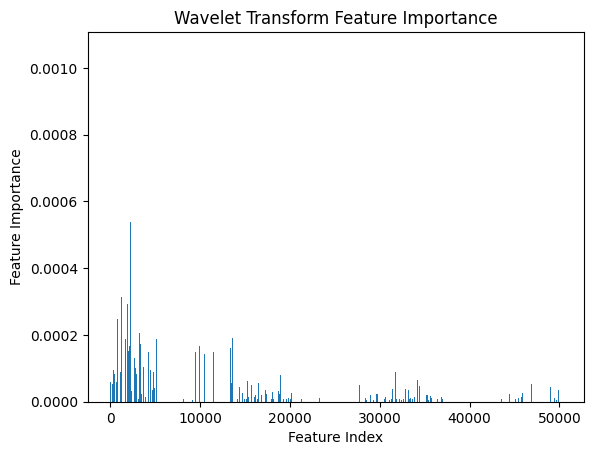

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Reshape the wavelet-transformed data
num_samples, img_s1, img_s2, num_channels = X_train_wave.shape
X_train_wave_2d = X_train_wave.reshape((num_samples, -1))

num_samples_test, _,_,_ = X_test_wave.shape
X_test_wave_2d = X_test_wave.reshape((num_samples_test, -1))

# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the wavelet-transformed features
rf_classifier.fit(X_train_wave_2d, y_train_wave)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_wave_2d)

# Evaluate accuracy
accuracy = accuracy_score(y_test_wave, y_pred)
print(f'Accuracy: {accuracy}')

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Visualize feature importances
import matplotlib.pyplot as plt

# Plot feature importances
plt.bar(range(X_train_wave_2d.shape[1]), feature_importances)
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Wavelet Transform Feature Importance')
plt.show()

In [29]:
wave_cnn_model = Sequential()

wave_cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112,4)))
wave_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

wave_cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
wave_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

wave_cnn_model.add(Conv2D(32, (3, 3), activation='relu'))
wave_cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

wave_cnn_model.add(Flatten())
wave_cnn_model.add(Dense(64, activation='relu'))
wave_cnn_model.add(tf.keras.layers.BatchNormalization())
wave_cnn_model.add(Dense(64, activation='relu'))
wave_cnn_model.add(tf.keras.layers.BatchNormalization())
wave_cnn_model.add(Dense(32, activation='relu'))
wave_cnn_model.add(tf.keras.layers.BatchNormalization())
wave_cnn_model.add(Dense(len(labels), activation='softmax'))

In [30]:
y_test_wave.shape

(252,)

In [31]:
import numpy as np

# Assuming X_train_wave and X_test_wave are your input data arrays
# Reshape the data to have the correct second dimension
X_train_wave = np.reshape(X_train_wave, (X_train_wave.shape[0], 112, 112, 4))
X_test_wave = np.reshape(X_test_wave, (X_test_wave.shape[0], 112, 112, 4))

# Now, you can proceed with model training
wave_cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
wave_cnn_model.fit(X_train_wave, y_train_wave, epochs=10, validation_data=(X_test_wave, y_test_wave))
wave_cnn_model.save("wave_cnn_model.h5")

Epoch 1/10
71/71 [==============================] - 30s 389ms/step - loss: 2.4438 - accuracy: 0.4127 - val_loss: 3.0479 - val_accuracy: 0.1984
Epoch 2/10
71/71 [==============================] - 26s 365ms/step - loss: 1.2029 - accuracy: 0.7905 - val_loss: 2.0333 - val_accuracy: 0.5357
Epoch 3/10
71/71 [==============================] - 26s 363ms/step - loss: 0.6309 - accuracy: 0.9218 - val_loss: 1.1107 - val_accuracy: 0.7659
Epoch 4/10
71/71 [==============================] - 26s 364ms/step - loss: 0.4432 - accuracy: 0.9412 - val_loss: 2.0069 - val_accuracy: 0.3889
Epoch 5/10
71/71 [==============================] - 26s 363ms/step - loss: 0.2701 - accuracy: 0.9682 - val_loss: 0.8753 - val_accuracy: 0.7421
Epoch 6/10
71/71 [==============================] - 26s 366ms/step - loss: 0.1442 - accuracy: 0.9925 - val_loss: 0.2948 - val_accuracy: 0.9444
Epoch 7/10
71/71 [==============================] - 26s 364ms/step - loss: 0.0934 - accuracy: 0.9960 - val_loss: 0.4726 - val_accuracy: 0.8889

c:\Users\Parth Tripathi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 1s 68ms/step


<Figure size 1000x1200 with 0 Axes>

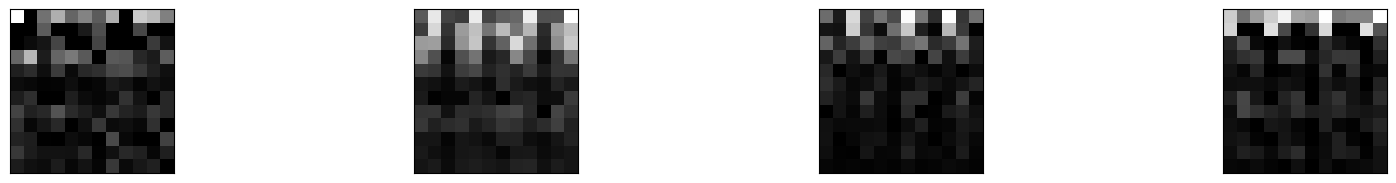

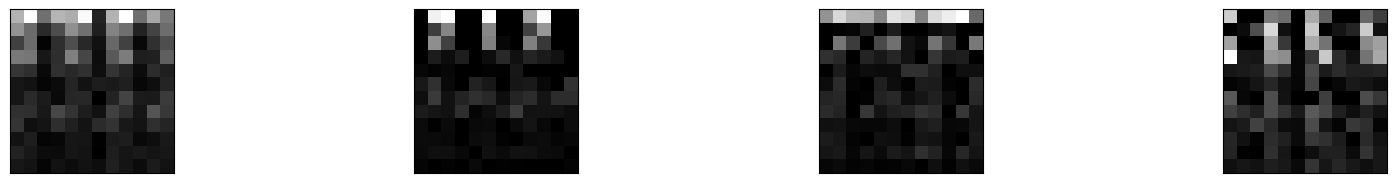

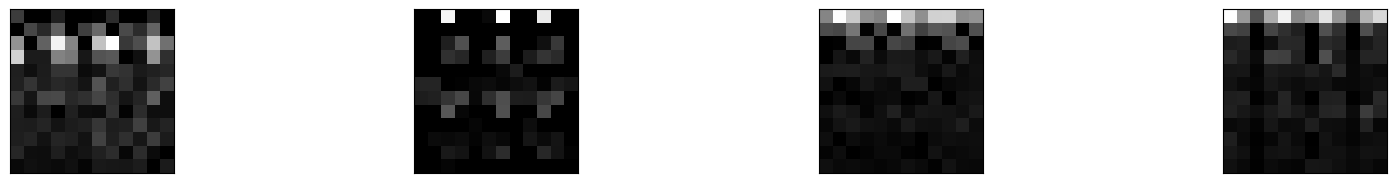

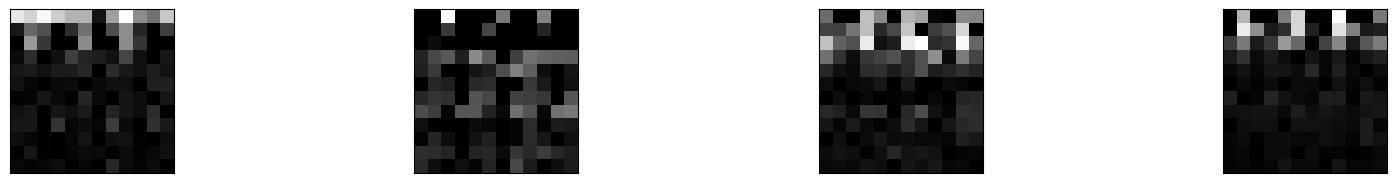

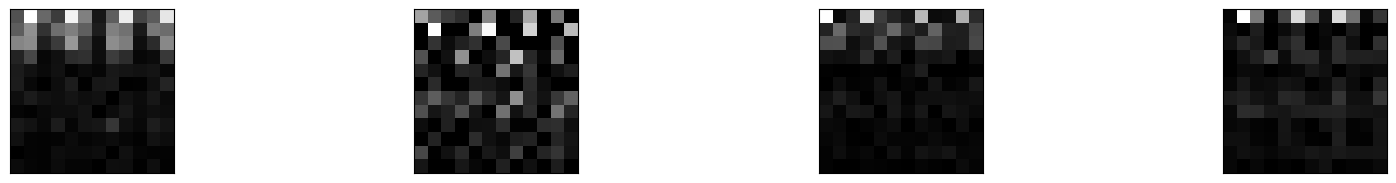

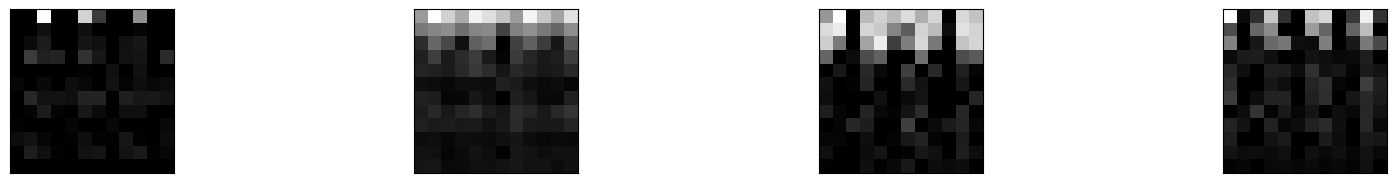

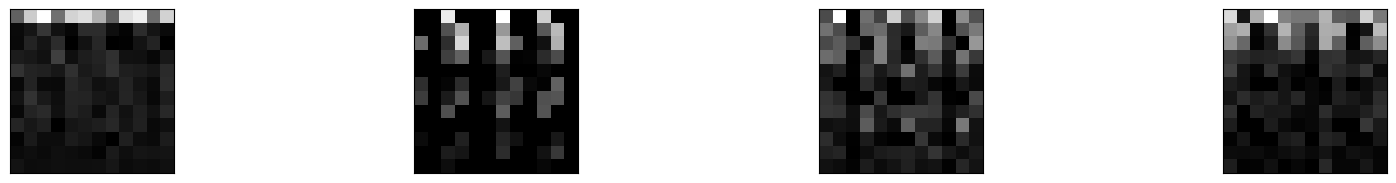

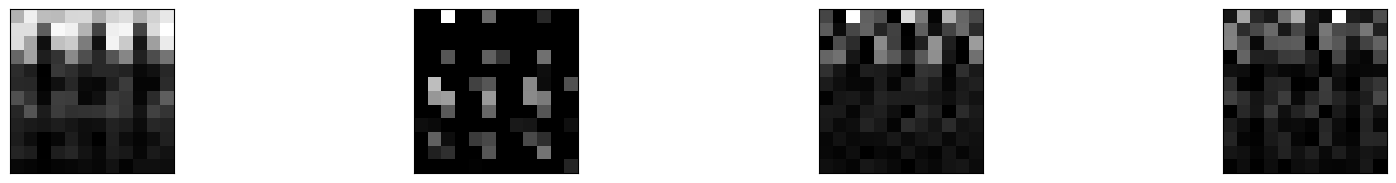

In [32]:
# Extract feature maps from the convolutional layer
import matplotlib.pyplot as plt
layer_outputs = [layer.output for layer in wave_cnn_model.layers[:6]]
activation_model = Sequential(wave_cnn_model.layers[:6])
feature_maps = activation_model.predict(X_test_wave)

# Visualize feature maps
square1 = 8
square2 = 4
ix = 1

plt.figure(figsize=(10, 12))

for _ in range(square1):
    plt.figure(figsize=(20, 20))
    for _ in range(square2):
        # specify subplot and turn off axis
        ax = plt.subplot(square1, square2, ix)
        ax.set_xticks([])
        ax.set_yticks([])

        # plot filter channel in grayscale
        plt.imshow(feature_maps[10, :, :, ix-1], cmap='gray')
        ix += 1

# show the figure
plt.show()

In [33]:
# Evaluate the model
test_loss, test_accuracy = wave_cnn_model.evaluate(X_test_wave, y_test_wave)
print(f'Test accuracy: {100*test_accuracy}')

8/8 [==============================] - 1s 82ms/step - loss: 0.3128 - accuracy: 0.9048
Test accuracy: 90.47619104385376
